# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

---

In [7]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)

In [8]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

In [9]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")

In [22]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [10]:
prostate <- read.csv("./prostate.csv")

In [11]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

# set the seed to make our partition reproductible
set.seed(123)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [12]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
863,863,5,8,10,9,2,2,8,6,2,3,0
2365,2365,4,4,2,4,4,1,3,7,3,9,0
1227,1227,7,4,9,2,4,2,3,9,9,8,0
2647,2647,5,5,7,2,4,1,8,10,1,7,3
2818,2818,10,1,2,5,7,2,8,5,9,5,1
137,137,8,1,2,10,10,2,2,3,1,5,0


In [13]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  863 2365 1227 2647 2818 137 1582 2672 1650 1366 ...
 $ ATT1  : int  5 4 7 5 10 8 7 2 2 5 ...
 $ ATT2  : int  8 4 4 5 1 1 1 10 1 4 ...
 $ ATT3  : int  10 2 9 7 2 2 5 5 6 10 ...
 $ ATT4  : int  9 4 2 2 5 10 4 8 2 7 ...
 $ ATT5  : int  2 4 4 4 7 10 8 5 8 10 ...
 $ ATT6  : int  2 1 2 1 2 2 1 4 2 10 ...
 $ ATT7  : int  8 3 3 8 8 2 9 2 3 3 ...
 $ ATT8  : int  6 7 9 10 5 3 2 6 4 8 ...
 $ ATT9  : int  2 3 9 1 9 1 6 1 1 10 ...
 $ ATT10 : int  3 9 8 7 5 5 7 3 4 2 ...
 $ Result: int  0 0 0 3 1 0 0 2 2 1 ...


Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [14]:
train$Result <- as.factor(train$Result) 

In [15]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [16]:
# Check the proportions of each factor within the Result variable
w = table(train$Result)
w


  0   1   2   3 
868 876 495 161 

In [17]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ID,1.000,2400.000,1518.159,866.749,1530.500,1522.436,1114.915,2.000,2999.000,2997.000,-0.034,-1.203,17.692
ATT1,2.000,2400.000,5.835,2.651,6.000,5.793,2.965,2.000,10.000,8.000,0.098,-1.160,0.054
ATT2,3.000,2400.000,4.510,2.736,4.000,4.327,2.965,1.000,10.000,9.000,0.401,-0.972,0.056
ATT3,4.000,2400.000,5.865,2.675,6.000,5.831,2.965,2.000,10.000,8.000,0.090,-1.189,0.055
ATT4,5.000,2400.000,5.807,2.630,6.000,5.759,2.965,2.000,10.000,8.000,0.090,-1.154,0.054
ATT5,6.000,2400.000,5.767,2.631,6.000,5.708,2.965,2.000,10.000,8.000,0.111,-1.144,0.054
ATT6,7.000,2400.000,4.450,2.699,4.000,4.264,2.965,1.000,10.000,9.000,0.433,-0.947,0.055
ATT7,8.000,2400.000,4.474,2.739,4.000,4.290,2.965,1.000,10.000,9.000,0.399,-1.026,0.056
ATT8,9.000,2400.000,4.499,2.729,4.000,4.317,2.965,1.000,10.000,9.000,0.386,-0.978,0.056
ATT9,10.000,2400.000,4.484,2.688,4.000,4.299,2.965,1.000,10.000,9.000,0.412,-0.918,0.055


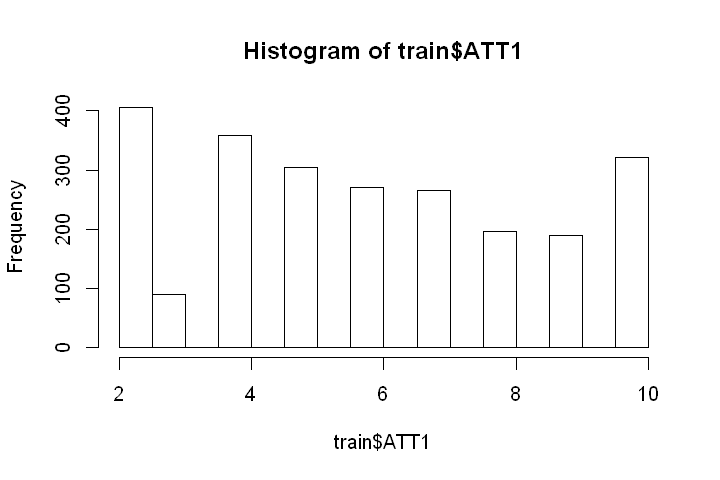

In [18]:
hist(train$ATT1)

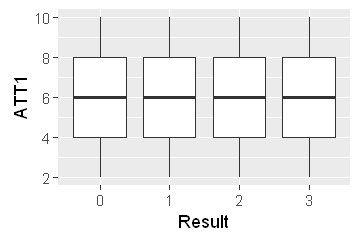

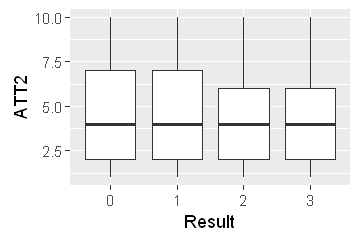

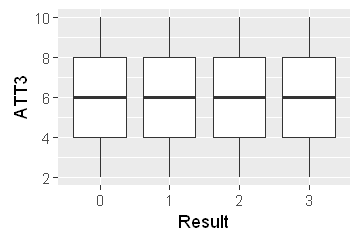

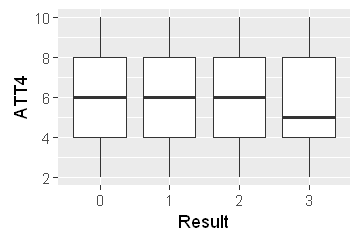

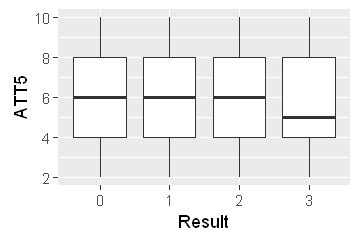

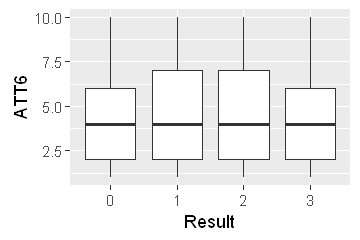

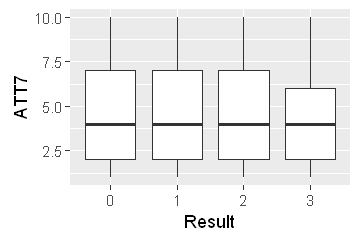

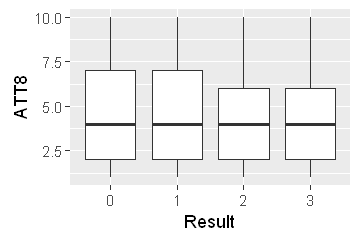

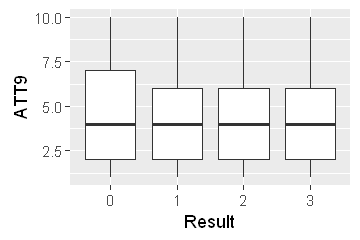

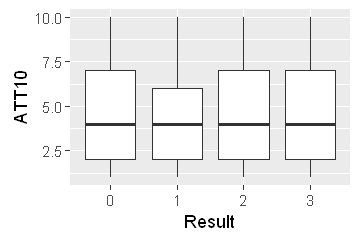

In [19]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

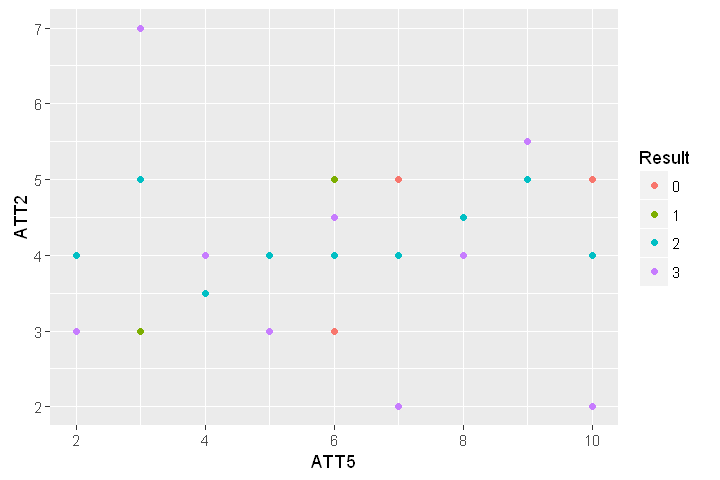

In [20]:
ggplot(aes(x=ATT5, y=ATT2, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

## 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

## 3. XGBoost